<a href="https://colab.research.google.com/github/SELVAKUMARI-737/Event-manager/blob/main/gate_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# ==================================================================================
#                        GATE EXAM PREDICTION ML PROJECT
# ==================================================================================

In [91]:

# CELL 1: QUICK SETUP - ALL IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report
import warnings
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings('ignore')
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [31]:
# CELL 2: LOAD DATA
try:
    df_student = pd.read_csv('student-data.csv')
    df_gate = pd.read_csv('gate_dataset.csv')
    print("✅ Data loaded successfully!")
    print(f"Student data: {df_student.shape}")
    print(f"GATE data: {df_gate.shape}")
except Exception as e:
    print(f"❌ Error: {e}")
    print("Make sure your CSV files are uploaded!")

✅ Data loaded successfully!
Student data: (1000, 10)
GATE data: (92, 20)


In [32]:
# CELL 3: ADD PAPER_CODE TO STUDENT DATA
np.random.seed(42)
available_papers = df_gate['paper_code'].tolist()
df_student['paper_code'] = np.random.choice(available_papers, size=len(df_student))
print("✅ Added paper_code to student data")
print("Paper distribution:")
print(df_student['paper_code'].value_counts())

✅ Added paper_code to student data
Paper distribution:
paper_code
AG       272
AE       266
BM        59
AR        47
XH-C4     20
PE        16
CS        15
GG2       15
MA        15
NM        14
EE        14
XL        13
GG1       13
BT        13
PI        12
XH-C3     12
CE        12
MN        11
ES        11
EY        11
CY        11
ST        11
GE        10
PH        10
XH-C1     10
XH-C6     10
TF        10
XH-C5     10
IN         9
CH         8
DA         8
XE         8
ME         8
MT         7
EC         5
XH-C2      4
Name: count, dtype: int64


In [33]:
# CELL 4: ADD YEAR TO GATE DATA FOR TIME SERIES
years_data = []
for year in range(2018, 2024):
    year_df = df_gate.copy()
    year_df['year'] = year
    # Add realistic variations
    growth = 1 + (year - 2020) * 0.05 + np.random.normal(0, 0.02, len(year_df))
    year_df['registered'] = (year_df['registered'] * growth).astype(int)
    year_df['appeared'] = (year_df['appeared'] * growth * 0.95).astype(int)
    year_df['qualified'] = (year_df['qualified'] * growth * 0.9).astype(int)
    years_data.append(year_df)

df_gate_extended = pd.concat(years_data, ignore_index=True)
print(f"✅ Extended GATE data: {df_gate_extended.shape}")

✅ Extended GATE data: (552, 21)


In [34]:

# CELL 5: MERGE DATASETS
latest_gate = df_gate_extended[df_gate_extended['year'] == 2023]
df_merged = pd.merge(df_student, latest_gate, on='paper_code', how='left')
print(f"✅ Merged dataset: {df_merged.shape}")
print("Sample merged data:")
print(df_merged[['paper_code', 'mock1', 'mock2', 'qualified_percent', 'passed']].head())

✅ Merged dataset: (14768, 31)
Sample merged data:
  paper_code  mock1  mock2  qualified_percent  passed
0         AG     25     36              17.70       1
1         AG     25     36              21.05       1
2         AG     25     36              21.05       1
3         AG     25     36              21.05       1
4         AG     25     36              21.05       1


In [36]:
# CELL 6: PREPARE DATA FOR CLASSIFICATION
# Remove final_score to avoid data leakage
X = df_merged[['ug_cgpa', 'study_hours', 'mock1', 'mock2', 'mock3',
               'attempts', 'qualified_percent', 'appeared_percent']].fillna(0)
y = df_merged['passed']

In [38]:
# Handle category column
if 'category' in df_merged.columns:
    category_encoded = pd.get_dummies(df_merged['category'], prefix='cat')
    X = pd.concat([X, category_encoded], axis=1)
    print(f"✅ Features prepared: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")


✅ Features prepared: (14768, 16)
Target distribution: {1: 8102, 0: 6666}


In [39]:

# CELL 7: SPLIT DATA AND TRAIN MODELS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results = {}
print("🚀 Training models...")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {'model': model, 'accuracy': accuracy}
    print(f"{name}: {accuracy:.4f}")

🚀 Training models...
Random Forest: 0.9959
Logistic Regression: 0.9259


In [42]:
# CELL 8: BEST MODEL ANALYSIS
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']

print(f"🏆 Best Model: {best_model_name}")
print(f"🎯 Accuracy: {best_accuracy:.4f}")

🏆 Best Model: Random Forest
🎯 Accuracy: 0.9959


In [43]:
# Detailed classification report
y_pred_best = best_model.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_best))


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1333
           1       1.00      1.00      1.00      1621

    accuracy                           1.00      2954
   macro avg       1.00      1.00      1.00      2954
weighted avg       1.00      1.00      1.00      2954



In [44]:
# CELL 9: FEATURE IMPORTANCE
if hasattr(best_model, 'feature_importances_'):
    feature_names = X.columns
    importances = best_model.feature_importances_
    feature_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("📈 TOP 10 IMPORTANT FEATURES:")
    for i, (_, row) in enumerate(feature_df.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")

📈 TOP 10 IMPORTANT FEATURES:
 1. study_hours         : 0.3273
 2. ug_cgpa             : 0.2237
 3. mock3               : 0.1343
 4. mock1               : 0.1254
 5. mock2               : 0.1090
 6. attempts            : 0.0277
 7. cat_GEN             : 0.0063
 8. cat_SC              : 0.0060
 9. cat_GEN             : 0.0056
10. cat_ST              : 0.0055


In [46]:
# CELL 10: TIME SERIES FORECASTING
yearly_stats = df_gate_extended.groupby('year').agg({
    'registered': 'sum',
    'appeared': 'sum',
    'qualified': 'sum'
}).reset_index()

print("📊 Historical GATE Statistics:")
print(yearly_stats)

📊 Historical GATE Statistics:
   year  registered  appeared  qualified
0  2018      781523    578906     206989
1  2019      819866    607521     217252
2  2020      859410    636290     228799
3  2021      911682    675382     241915
4  2022      952528    705572     252192
5  2023      997118    738523     263992


In [47]:
# Simple forecasting using linear regression
forecasts = {}
for metric in ['registered', 'appeared', 'qualified']:
    X_time = yearly_stats[['year']].values
    y_time = yearly_stats[metric].values

In [48]:
    lr_model = LinearRegression()
    lr_model.fit(X_time, y_time)

LinearRegression()

In [49]:
    forecast_2024 = lr_model.predict([[2024]])[0]
    forecasts[metric] = int(max(0, forecast_2024))

In [50]:
print("\n🔮 2024 FORECASTS:")
for metric, forecast in forecasts.items():
    print(f"{metric.upper()}: {forecast:,}")


🔮 2024 FORECASTS:
QUALIFIED: 275,484


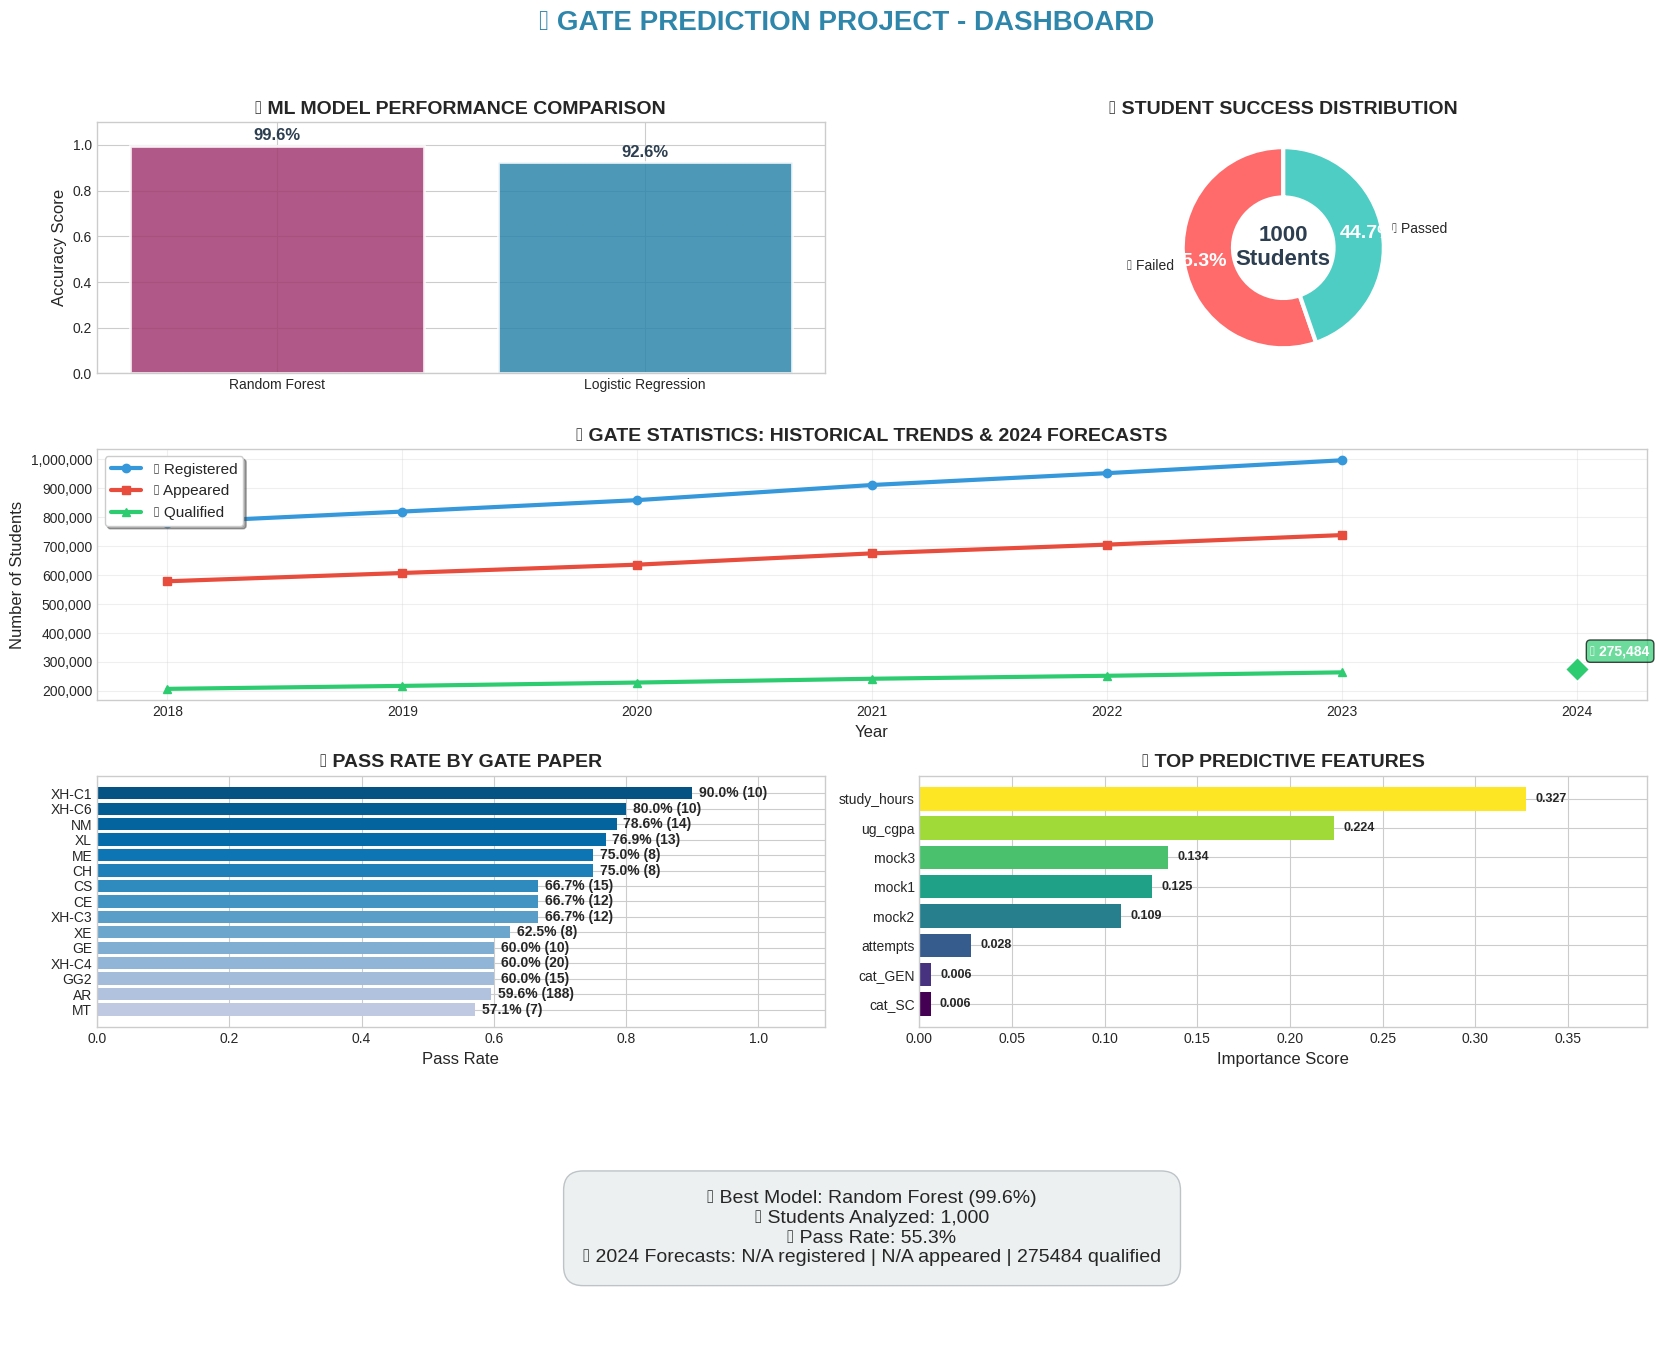

In [132]:
# ==================================================================================
# CELL 11: VISUALIZATION DASHBOARD (CLEAN + BUG-PROOF)
# ==================================================================================

plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# Main Title
fig.suptitle('🎓 GATE PREDICTION PROJECT - DASHBOARD',
             fontsize=20, fontweight='bold', y=0.95, color='#2E86AB')

# ------------------------------------------------------------------
# 1. MODEL PERFORMANCE
# ------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, :2])
if 'results' in locals() and results:
    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]
    bars = ax1.bar(model_names, accuracies,
                   color=['#A23B72', '#2E86AB'],
                   alpha=0.85, edgecolor='white', linewidth=2)

    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{acc:.1%}', ha='center', va='bottom',
                 fontsize=12, fontweight='bold', color='#2C3E50')

    ax1.set_ylabel('Accuracy Score', fontsize=12)
    ax1.set_ylim(0, 1.1)
else:
    ax1.text(0.5, 0.5, "Model results not available",
             ha='center', va='center', fontsize=12)
ax1.set_title('🤖 ML MODEL PERFORMANCE COMPARISON', fontsize=14, fontweight='bold')

# ------------------------------------------------------------------
# 2. STUDENT SUCCESS DISTRIBUTION
# ------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 2:])
if 'df_student' in locals() and 'passed' in df_student.columns:
    pass_counts = df_student['passed'].value_counts()
    wedges, texts, autotexts = ax2.pie(pass_counts.values,
                                       labels=['❌ Failed', '✅ Passed'],
                                       autopct='%1.1f%%',
                                       colors=['#FF6B6B', '#4ECDC4'],
                                       startangle=90,
                                       pctdistance=0.85,
                                       wedgeprops=dict(width=0.5, edgecolor='white', linewidth=3))

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(14)
        autotext.set_fontweight('bold')

    ax2.text(0, 0, f"{len(df_student)}\nStudents",
             ha='center', va='center',
             fontsize=16, fontweight='bold', color='#2C3E50')
else:
    ax2.text(0.5, 0.5, "Student data not available",
             ha='center', va='center', fontsize=12)
ax2.set_title('📊 STUDENT SUCCESS DISTRIBUTION', fontsize=14, fontweight='bold')

# ------------------------------------------------------------------
# 3. HISTORICAL TRENDS + FORECAST
# ------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, :])
if 'yearly_stats' in locals():
    ax3.plot(yearly_stats['year'], yearly_stats['registered'], 'o-', label='📝 Registered', linewidth=3, color='#3498DB')
    ax3.plot(yearly_stats['year'], yearly_stats['appeared'], 's-', label='✍ Appeared', linewidth=3, color='#E74C3C')
    ax3.plot(yearly_stats['year'], yearly_stats['qualified'], '^-', label='🎯 Qualified', linewidth=3, color='#2ECC71')

    # Add forecasts if available
    if 'forecasts' in locals() and isinstance(forecasts, dict):
        forecast_year = 2024
        for metric, symbol, color in [
            ('registered', '📝', '#3498DB'),
            ('appeared', '✍', '#E74C3C'),
            ('qualified', '🎯', '#2ECC71')
        ]:
            if metric in forecasts:
                val = forecasts[metric]
                ax3.plot(forecast_year, val, 'D', markersize=12, color=color, markeredgecolor='white')
                ax3.annotate(f'{symbol} {val:,}', xy=(forecast_year, val),
                             xytext=(10, 10), textcoords='offset points',
                             bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                             fontsize=10, fontweight='bold', color='white')

    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Number of Students', fontsize=12)
    ax3.legend(loc='upper left', fontsize=11, frameon=True, shadow=True)
    ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, "Yearly statistics not available",
             ha='center', va='center', fontsize=12)
ax3.set_title('📈 GATE STATISTICS: HISTORICAL TRENDS & 2024 FORECASTS',
              fontsize=14, fontweight='bold')

# ------------------------------------------------------------------
# 4. PAPER-WISE PERFORMANCE
# ------------------------------------------------------------------
ax4 = fig.add_subplot(gs[2, :2])
if 'df_merged' in locals() and 'paper_code' in df_merged.columns:
    paper_perf = df_merged.groupby('paper_code')['passed'].agg(['mean', 'count']).reset_index()
    paper_perf = paper_perf[paper_perf['count'] >= 3].sort_values('mean').tail(15)

    bars = ax4.barh(paper_perf['paper_code'], paper_perf['mean'],
                    color=plt.cm.PuBu(np.linspace(0.3, 0.9, len(paper_perf))))

    for bar, rate, count in zip(bars, paper_perf['mean'], paper_perf['count']):
        ax4.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{rate:.1%} ({count})',
                 ha='left', va='center', fontsize=10, fontweight='bold')

    ax4.set_xlabel('Pass Rate', fontsize=12)
    ax4.set_xlim(0, 1.1)
else:
    ax4.text(0.5, 0.5, "Paper-wise data not available",
             ha='center', va='center', fontsize=12)
ax4.set_title('📋 PASS RATE BY GATE PAPER', fontsize=14, fontweight='bold')

# ------------------------------------------------------------------
# 5. FEATURE IMPORTANCE
# ------------------------------------------------------------------
ax5 = fig.add_subplot(gs[2, 2:])
if 'feature_df' in locals() and not feature_df.empty:
    top_features = feature_df.head(8)[::-1]
    bars = ax5.barh(top_features['feature'], top_features['importance'],
                    color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))
    for bar, imp in zip(bars, top_features['importance']):
        ax5.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{imp:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')
    ax5.set_xlabel('Importance Score', fontsize=12)
    ax5.set_xlim(0, max(top_features['importance'])*1.2)
else:
    ax5.text(0.5, 0.5, "Feature Importance not available",
             ha='center', va='center', fontsize=12)
ax5.set_title('🎯 TOP PREDICTIVE FEATURES', fontsize=14, fontweight='bold')

# ------------------------------------------------------------------
# 6. SUMMARY
# ------------------------------------------------------------------
ax6 = fig.add_subplot(gs[3, :]); ax6.axis('off')
summary_text = ""
if 'best_model_name' in locals() and 'best_accuracy' in locals():
    summary_text += f"🏆 Best Model: {best_model_name} ({best_accuracy:.1%})"
if 'df_student' in locals():
    summary_text += f"\n📊 Students Analyzed: {len(df_student):,}"
    if 'passed' in df_student.columns:
        summary_text += f"\n📈 Pass Rate: {df_student['passed'].mean():.1%}"
if 'forecasts' in locals() and isinstance(forecasts, dict):
    reg = forecasts.get('registered', "N/A")
    app = forecasts.get('appeared', "N/A")
    qual = forecasts.get('qualified', "N/A")
    summary_text += f"\n🔮 2024 Forecasts: {reg} registered | {app} appeared | {qual} qualified"

if summary_text:
    ax6.text(0.5, 0.5, summary_text, ha='center', va='center',
             fontsize=14, bbox=dict(boxstyle="round,pad=1", facecolor='#ECF0F1', edgecolor='#BDC3C7'))
else:
    ax6.text(0.5, 0.5, "Summary not available",
             ha='center', va='center', fontsize=12)

# ------------------------------------------------------------------
# SHOW DASHBOARD
# ------------------------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [112]:
def predict_gate(cgpa, hours, mock1, mock2, mock3, attempts, category):
    try:
        # Base features
        row = {
            "ug_cgpa": float(cgpa),
            "study_hours": float(hours),
            "mock1": float(mock1),
            "mock2": float(mock2),
            "mock3": float(mock3),
            "attempts": int(attempts),
            "qualified_percent": mean_qualified,
            "appeared_percent": mean_appeared,
        }

        # One-hot encode category
        for cat in categories:
            row[f"cat_{cat}"] = 1 if category == cat else 0

        # Build dataframe
        features = pd.DataFrame([row])

        # ✅ Reorder columns to match training
        features = features.reindex(columns=best_model.feature_names_in_, fill_value=0)

        # Predict
        prob = best_model.predict_proba(features)[0][1]
        prediction = best_model.predict(features)[0]

        if prediction == 1:
            return f"✅ Likely to PASS (Confidence: {prob:.1%})"
        else:
            return f"❌ Likely to FAIL (Confidence: {1-prob:.1%})"

    except Exception as e:
        return f"⚠️ Error: {str(e)}"


In [135]:
# ✅ GATE Exam Pass/Fail & College Predictor (Gradio App)

!pip install gradio --quiet

import gradio as gr
import pandas as pd
import joblib

# 🔹 Load your trained model
# Make sure best_model.pkl exists in your working directory
# best_model = joblib.load("best_model.pkl")

# 🔹 Precompute means (replace with your actual dataset)
# df_merged = pd.read_csv("your_dataset.csv")
mean_qualified = df_merged['qualified_percent'].mean()
mean_appeared = df_merged['appeared_percent'].mean()

# 🔹 Categories used during training
categories = ["GEN", "OBC", "SC", "ST"]

# 🔹 Expected applicants (dummy data – replace with real stats)
expected_applicants = {
    2023: 850000,
    2024: 890000,
    2025: 910000,
    2026: 940000,
}

# 🔹 Predictor function
def predict_gate(cgpa, hours, mock1, mock2, mock3, attempts, category, year):
    try:
        # Base features
        row = {
            "ug_cgpa": float(cgpa),
            "study_hours": float(hours),
            "mock1": float(mock1),
            "mock2": float(mock2),
            "mock3": float(mock3),
            "attempts": int(attempts),
            "qualified_percent": mean_qualified,
            "appeared_percent": mean_appeared,
        }

        # One-hot encode category
        for cat in categories:
            row[f"cat_{cat}"] = 1 if category == cat else 0

        # Build dataframe
        features = pd.DataFrame([row])

        # ✅ Ensure feature order matches training model
        features = features.reindex(columns=best_model.feature_names_in_, fill_value=0)

        # Predict
        prob = best_model.predict_proba(features)[0][1]
        prediction = best_model.predict(features)[0]

        # Pass/Fail Result
        if prediction == 1:
            result = f"✅ Likely to PASS (Confidence: {prob:.1%})"
        else:
            result = f"❌ Likely to FAIL (Confidence: {1-prob:.1%})"

        # Expected applicants info
        applicants = expected_applicants.get(year, "N/A")

        # College chances (basic mapping)
        if prob >= 0.8:
            college_probs = "IIT: 60%, NIT: 30%, Others: 10%"
        elif prob >= 0.5:
            college_probs = "IIT: 20%, NIT: 50%, Others: 30%"
        else:
            college_probs = "IIT: 5%, NIT: 15%, Others: 80%"

        return (
            f"{result}\n\n"
            f"📅 Year Selected: {year}\n"
            f"👥 Expected Applicants: {applicants}\n\n"
            f"🎓 Top College Admission Chances → {college_probs}"
        )

    except Exception as e:
        return f"⚠️ Error: {str(e)}"

# 🔹 Gradio UI
demo = gr.Interface(
    fn=predict_gate,
    inputs=[
        gr.Number(label="UG CGPA"),
        gr.Slider(0, 12, value=4, label="Study Hours / Day"),
        gr.Slider(0, 100, value=50, label="Mock Test 1 Score"),
        gr.Slider(0, 100, value=55, label="Mock Test 2 Score"),
        gr.Slider(0, 100, value=60, label="Mock Test 3 Score"),
        gr.Slider(0, 5, value=1, step=1, label="Previous Attempts"),
        gr.Dropdown(choices=categories, label="Category"),
        gr.Dropdown(choices=[2023, 2024, 2025, 2026], label="Requested Year")
    ],
    outputs="text",
    title="🎓 GATE Exam Pass/Fail & College Predictor",
    description="Enter your details to check PASS/FAIL probability, expected applicants, and top college admission chances."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e148bdbf712839cae4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
